# Importing Libraries

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import folium
from bs4 import BeautifulSoup
from sklearn import preprocessing
import re
import seaborn as sns

# Data sources
The data sources used in this capstone are taken from: 
1.  [New York City Neighborhood Names](https://geo.nyu.edu/catalog/nyu_2451_34572)
2.  [Foursquare Venue Data](https://developer.foursquare.com/docs/api/venues/details)
3.  [New York City Crime Rate Data](https://data.cityofnewyork.us/Public-Safety/Crime-Map-/5jvd-shfj)
4.  New York City Average Apartment Rental Price By Neighborhood:
    [Manhattan](https://www.rentcafe.com/average-rent-market-trends/us/ny/manhattan/)
    [Brooklyn](https://www.rentcafe.com/average-rent-market-trends/us/ny/brooklyn/)
    [Bronx](https://www.rentcafe.com/average-rent-market-trends/us/ny/bronx/)
    [Queens](https://www.rentcafe.com/average-rent-market-trends/us/ny/queens/)
5.  [Best New York City Neighborhoods to Live In](https://www.niche.com/places-to-live/search/best-neighborhoods/m/new-york-city-metro-area/)

We begin with loading the New York City Neighborhood Names data set. It is in the form of a JSON file

In [110]:
nynb_data_loc = './Data/New York City Neighborhoods.json'
with open(nynb_data_loc) as json_data:
    nynb_data = json.load(json_data)


Now we create four lists and insert all the neighborhood data from the JSON file into it

In [111]:
# Making four lists to house the neighborhood information into it
boroughs = []
neighborhoods = []
latitude = []
longitude = []

# This for loop goes through the json file and adds each borough,neighborhood,latitude, and longitude value to its 
# respective list  
for i in nynb_data['features']:
    boroughs.append(i['properties']['borough'])
    neighborhoods.append(i['properties']['name'])
    latitude.append(i['properties']['bbox'][1])
    longitude.append(i['properties']['bbox'][0])

In [112]:
# Creating the data frame that houses all the neighborhood info and then adding the 4 lists to it
NYNB = pd.DataFrame()
NYNB['Borough'] = boroughs
NYNB['Neighborhood'] = neighborhoods
NYNB['Latitude'] = latitude
NYNB['Longitude'] = longitude
NYNB.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Let us access the venue data using the Foursquare API

In [113]:
# Foursquare credentials
client_id = 'IMYGI0FJBA40GAV1545T4FXXVIIODTDIYBTOEDNMHIUCBN4N'
client_secret = 'TG30YWCZ031V20URB4OVXWRLEJ0LBKXUDUNOGFJQOU53K1QT'

# Function that extracts the category of a venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    

Let us check the nearby venues for the first neighborhood

In [114]:
# Coordinates of the Madison neighborhood
latitude = NYNB['Latitude'][296]
longitude = NYNB['Longitude'][296]
radius = 1000
limit = 100

# Getting the top 10 trending venues in a 500m radius from the neighborhood
url = f'https://api.foursquare.com/v2/search/recommendations?&client_id={client_id}&client_secret={client_secret}&v=20180605&ll={latitude},{longitude}&radius={radius}&limit={limit}'
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5d09f5c2c53093002c61c7ca'},
 'response': {'group': {'results': [{'displayType': 'venue',
     'venue': {'id': '4b4b9a1ff964a5209fa126e3',
      'name': 'Nagoya Sushi',
      'location': {'address': '1907 Kings Hwy',
       'crossStreet': 'at E 19th St',
       'lat': 40.610420177453136,
       'lng': -73.95443181531823,
       'labeledLatLngs': [{'label': 'display',
         'lat': 40.610420177453136,
         'lng': -73.95443181531823}],
       'distance': 521,
       'postalCode': '11229',
       'cc': 'US',
       'city': 'Brooklyn',
       'state': 'NY',
       'country': 'United States',
       'formattedAddress': ['1907 Kings Hwy (at E 19th St)',
        'Brooklyn, NY 11229',
        'United States']},
      'categories': [{'id': '4bf58dd8d48988d1d2941735',
        'name': 'Sushi Restaurant',
        'pluralName': 'Sushi Restaurants',
        'shortName': 'Sushi',
        'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/sushi_',

Cleaning the JSON file

In [115]:
venues = results['response']['group']['results']
venues
nearby_venues = json_normalize(venues) # flatten JSON

filtered_columns = ['venue.name', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]


In [116]:
nearby_venues

,name,lat,lng
0,Nagoya Sushi,40.610420,-73.954432
1,Pronto Pizza,40.607327,-73.943041
2,Michael's Pastry Shop,40.607385,-73.943376
3,Memo Shish Kebab,40.610332,-73.954865
4,Michael's,40.607520,-73.943044
5,Dunkin',40.610520,-73.954520
6,King's Pizza,40.608539,-73.957268
7,Marine Park Track,40.607446,-73.937127
8,Highway Bagels,40.610686,-73.953962
9,My Favorite Bagel,40.609993,-73.943642


Now that we have all the venues for one neighborhood let us create a function to get all the venues for all the neighborhoods

In [117]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        url = f'https://api.foursquare.com/v2/search/recommendations?&client_id={client_id}&client_secret={client_secret}&v=20180605&ll={lat},{lng}&radius={radius}&limit=100'
        results = requests.get(url).json()["response"]['group']['results']        
        venues_list.append([(name, v['venue']['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 'Venue']
    
    return(nearby_venues)

Since we have over 300 neighborhoods lets use this function later on when the list of neighborhoods gets smaller.

Now its time to collect information on New York City's criminal activity.
The next data set comes from the city of New York and it shows crimes and the locations of where the crimes occured

In [118]:
crime_data = pd.read_csv('./Data/New York City Crimes.csv')
crime_data.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,ADDR_PCT_CD,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,251527331,03/31/2019,23:50:00,04/01/2019,00:10:00,03/31/2019,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,...,114,INSIDE,RESIDENCE - PUBLIC HOUSING,NaN,NaN,1001557.0,217404.0,40.763391,-73.937525,"(40.76339148500005, -73.93752515999995)"
1,440213705,03/31/2019,23:50:00,04/01/2019,00:10:00,03/31/2019,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,...,114,FRONT OF,RESIDENCE - PUBLIC HOUSING,NaN,NaN,1001557.0,217404.0,40.763391,-73.937525,"(40.76339148500005, -73.93752515999995)"
2,607477539,03/31/2019,23:00:00,03/31/2019,23:15:00,03/31/2019,106,FELONY ASSAULT,109.0,"ASSAULT 2,1,UNCLASSIFIED",...,45,INSIDE,RESIDENCE-HOUSE,NaN,NaN,1026297.0,244171.0,40.836776,-73.848049,"(40.836776445000055, -73.84804910999998)"
3,356729172,03/31/2019,23:00:00,03/31/2019,23:05:00,03/31/2019,126,MISCELLANEOUS PENAL LAW,198.0,CRIMINAL CONTEMPT 1,...,109,INSIDE,RESIDENCE - PUBLIC HOUSING,NaN,LATIMER GARDENS,1031088.0,218649.0,40.766702,-73.830913,"(40.766701556000044, -73.83091313699998)"
4,225899019,03/31/2019,23:00:00,03/31/2019,23:05:00,03/31/2019,351,CRIMINAL MISCHIEF & RELATED OF,259.0,"CRIMINAL MISCHIEF,UNCLASSIFIED 4",...,46,FRONT OF,RESIDENCE - APT. HOUSE,NaN,NaN,1005725.0,249742.0,40.852141,-73.922376,"(40.85214118700002, -73.92237572199997)"


Thats a lot of columns. Lets take a look at a list of all the columns and see what interests us

In [119]:
crime_data.columns.values

array(['CMPLNT_NUM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'CMPLNT_TO_DT',
       'CMPLNT_TO_TM', 'RPT_DT', 'KY_CD', 'OFNS_DESC', 'PD_CD', 'PD_DESC',
       'CRM_ATPT_CPTD_CD', 'LAW_CAT_CD', 'JURIS_DESC', 'BORO_NM',
       'ADDR_PCT_CD', 'LOC_OF_OCCUR_DESC', 'PREM_TYP_DESC', 'PARKS_NM',
       'HADEVELOPT', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude',
       'Lat_Lon'], dtype=object)

We are interested in the Borough, Latitude, and Longitude columns

In [120]:
crime_data = crime_data[['BORO_NM','Latitude', 'Longitude']]
crime_data

,BORO_NM,Latitude,Longitude
0,QUEENS,40.763391,-73.937525
1,QUEENS,40.763391,-73.937525
2,BRONX,40.836776,-73.848049
3,QUEENS,40.766702,-73.830913
4,BRONX,40.852141,-73.922376
5,BRONX,40.822570,-73.911307
6,QUEENS,40.677605,-73.828219
7,MANHATTAN,40.745227,-74.004116
8,BRONX,40.805226,-73.914747
9,QUEENS,40.580403,-73.831536


Let us clean the data a little bit

In [121]:
crime_data['BORO_NM'].dropna(axis = 0, inplace = True)
crime_data['BORO_NM'] = crime_data['BORO_NM'].apply(lambda x : x.capitalize())

In [122]:
crime_data.rename({'BORO_NM' : 'Crime_Borough', 'Latitude' : 'Crime_Latitude', 'Longitude' : 'Crime_Longitude'}, axis = 1,inplace = True)

In [123]:
crime_data.shape

(105069, 3)

This is a very large data set (OVER 100,000!) for our purposes we dont need a dataset this large so lets just use the first 1000 crimes

In [124]:
crime_data = crime_data[0:1000]

Now you may have noticed that the crime_data dataframe does not have a neighborhood column. No need to worry we can use LocationIQ's reverse geocoding service to find the neighborhood name for each coordinate pair

In [125]:
# LocationIQ credentials
access_token = 'pk.be0335719a45f97e8715b8e81c1f4820'

# Let's get the neigjborhood for the first crime
crime_lat = crime_data['Crime_Latitude'][0]
crime_long = crime_data['Crime_Longitude'][0]
url = f'https://us1.locationiq.com/v1/reverse.php?key={access_token}&lat={crime_lat}&lon={crime_long}&format=json'
results = requests.get(url).json()
results

{'place_id': '333233966211',
 'licence': 'https://locationiq.com/attribution',
 'lat': '40.763563',
 'lon': '-73.937785',
 'display_name': '34-28, 12 St, Long Island City, New York, Queens County, New York, United States, 11106',
 'boundingbox': ['40.763563', '40.763563', '-73.937785', '-73.937785'],
 'importance': 0.2,
 'address': {'house_number': '34-28',
  'road': '12 St',
  'neighbourhood': 'Long Island City',
  'city': 'New York',
  'county': 'Queens County',
  'state': 'New York',
  'country': 'United States',
  'postcode': '11106',
  'country_code': 'us'}}

Now we extract the neighborhood data from the JSON result

In [126]:
results['address']['neighbourhood']

'Long Island City'

Now we extract the neighborhood data from every crime and add it into a new data frame. This takes a very long time

In [127]:
crime_neighborhoods = []
for x in range(len(crime_data['Crime_Latitude'])):
    crime_lat = crime_data['Crime_Latitude'][x]
    crime_long = crime_data['Crime_Longitude'][x]
    url = f'https://us1.locationiq.com/v1/reverse.php?key={access_token}&lat={crime_lat}&lon={crime_long}&format=json'
    results = requests.get(url).json()
    try:
        crime_neighborhoods.append(results['address']['neighbourhood'])
        print(results['address']['neighbourhood'])
    except:
        crime_neighborhoods.append(np.nan)
        print(np.nan)

Long Island City
Long Island City
Westchester Square
Flushing
Morris Heights
Melrose
Richmond Hill
Chelsea
Mott Haven
Rockaway Park
Bedford-Stuyvesant
Richmond Hill
Flatbush
Port Richmond
nan
East New York
Astoria
Jamaica
Bedford-Stuyvesant
Parkchester
Mott Haven
Flatbush
Tribeca
Ridgewood
Midtown West
St. George
Ridgewood
Sheepshead Bay
Washington Heights
Mott Haven
North Corona
Soundview Bruckner
Mott Haven
Kensington
Forest Hills
Forest Hills
Astoria
East Morrisania
East New York
Flatbush
Morris Heights
Fort Greene
Fordham
East Elmhurst
Stuyvesant Town
Astoria
Prospect-Lefferts Gardens
Prospect-Lefferts Gardens
Mill Basin
Williamsburg
Richmond Hill
St. George
Midtown West
Bushwick
East Village
Bushwick
Brownsville
Fresh Meadows
East New York
Rockaway Beach
Rockaway Beach
Forest Hills
Bedford-Stuyvesant
Midtown West
Bedford-Stuyvesant
Midtown East
Gramercy
Allerton
Allerton
Allerton
Allerton
Allerton
Two Bridges
Throgs Neck
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


East Harlem
Morris Heights
Upper West Side
Bronxdale
East Harlem
Bayridge
Washington Heights
Fordham
Upper East Side
Kingsbridge
Bushwick
Ridgewood
Upper East Side
Graniteville
East Elmhurst
Hamilton Heights
Edenwald
Crown Heights
Longwood
Hamilton Heights
Kingsbridge
Forest Hills
Van Nest
Tompkinsville
Kensington
Whitestone
Kingsbridge
Kingsbridge
Elmhurst
St. Albans
Bushwick
East Flatbush
Central Harlem
Brownsville
Forest Hills
Fordham
Bedford-Stuyvesant
South Ozone Park
Rockaway Park
Clinton Hill
Flatiron District
Bedford-Stuyvesant
Central Harlem
Long Island City
Sheepshead Bay
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
Jackson Heights
Kingsbridge
Cypress Hills
Gramercy
Norwood
Bayridge
Gravesend
Chelsea
Nolita
Central Harlem
Kensington
Allerton
Prospect-Lefferts Gardens
Throgs Neck
Central Harlem
Glendale
Morris Park
Chelsea
Longwood
East New York
Williamsburg
Williamsburg
Forest Hills
Longwood
East Harlem
Wakefi

In [128]:
crime_data['Crime_Neighborhood'] = crime_neighborhoods

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Lets drop missing values

In [129]:
crime_data.dropna(axis = 0, inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Lets group the crime activity by neighborhood

In [130]:
CNYN = crime_data.groupby(['Crime_Neighborhood']).count()

In [131]:
CNYN.reset_index(inplace = True)
CNYN.rename({'Crime_Neighborhood' : 'Neighborhood', 'Crime_Borough' : 'Num_of_Crimes'}, axis = 1, inplace = True)
CNYN = CNYN[['Neighborhood', 'Num_of_Crimes']]

In [132]:
CNYN.head()

,Neighborhood,Num_of_Crimes
0,Allerton,10
1,Arrochar,2
2,Arverne,2
3,Astoria,9
4,Bath Beach,2


In [133]:
print(CNYN.shape)
print(CNYN['Num_of_Crimes'].sum())

(153, 2)
673


Lets move on to the next dataset which is the apartment rental cost. This dataset will have to be scraped from a website using beautifulsoup

In [134]:
# Making two lists that will house the neighborhood names and rent cost in queens
qnbhd = []
qrent = []
# Getting the html from the web
qsource = requests.get('https://www.rentcafe.com/average-rent-market-trends/us/ny/queens/').text
qsoup = BeautifulSoup(qsource, 'lxml')
qsoup = qsoup.find(id = 'MarketTrendsAverageRentTable')
for i in qsoup.find('tbody').find_all(class_ = 'current-row'):
    qnbhd.append(i.th.text)
    qrent.append(i.td.text[1:])

In [135]:
# Making the dataframe
q_nbhds_rent = pd.DataFrame()

# Adding neighborhood names and rent to the dataframe
q_nbhds_rent['Neighborhood'] = qnbhd
# Removing the commas from the rent and converting to integer
q_nbhds_rent['Rent'] = list(map(lambda x: int(x.replace(',', '')) ,qrent))
q_nbhds_rent

,Neighborhood,Rent
0,Hollis,1037
1,South Astoria,1550
2,Jamaica Estates,1712
3,Murray Hill,1719
4,College Point,1719
5,Auburndale,1750
6,Pomonok,1766
7,Jamaica Hills,1766
8,Fresh Meadows,1766
9,Jamaica,1773


Now we are done with the data for the queens neighborhoods.
Let us repeat the process with Brooklyn, Bronx, and Manhattan

In [136]:
# Making two lists that will house the neighborhood names and rent cost in Brooklyn
brooknbhd = []
brookrent = []
# Getting the html from the web
brooksource = requests.get('https://www.rentcafe.com/average-rent-market-trends/us/ny/brooklyn/').text
brooksoup = BeautifulSoup(brooksource, 'lxml')
brooksoup = brooksoup.find(id = 'MarketTrendsAverageRentTable')

for i in brooksoup.find('tbody').find_all(class_ = 'current-row'):
    brooknbhd.append(i.th.text)
    brookrent.append(i.td.text[1:])
    
# Making the dataframe
brook_nbhds_rent = pd.DataFrame()

# Adding neighborhood names and rent to the dataframe
brook_nbhds_rent['Neighborhood'] = brooknbhd
# Removing the commas from the rent and converting to integer
brook_nbhds_rent['Rent'] = list(map(lambda x: int(x.replace(',', '')) ,brookrent))
brook_nbhds_rent

,Neighborhood,Rent
0,Flatlands,1492
1,Marine Park,1659
2,Madison,1659
3,Gerritsen Beach,1659
4,Homecrest,1717
5,Bensonhurst,1795
6,Bath Beach,1795
7,Midwood,1825
8,Fiske Terrace,1825
9,Kensington,1839


In [137]:
# Making two lists that will house the neighborhood names and rent cost in Bronx
bronxnbhd = []
bronxrent = []
# Getting the html from the web
bronxsource = requests.get('https://www.rentcafe.com/average-rent-market-trends/us/ny/bronx/').text
bronxsoup = BeautifulSoup(bronxsource, 'lxml')
bronxsoup = bronxsoup.find(id = 'MarketTrendsAverageRentTable')

for i in bronxsoup.find('tbody').find_all(class_ = 'current-row'):
    bronxnbhd.append(i.th.text)
    bronxrent.append(i.td.text[1:])
    
# Making the dataframe
bronx_nbhds_rent = pd.DataFrame()

# Adding neighborhood names and rent to the dataframe
bronx_nbhds_rent['Neighborhood'] = bronxnbhd
# Removing the commas from the rent and converting to integer
bronx_nbhds_rent['Rent'] = list(map(lambda x: int(x.replace(',', '')) ,bronxrent))
bronx_nbhds_rent

,Neighborhood,Rent
0,Spuyten Duyvil,1694
1,Riverdale,1694
2,Kingsbridge Heights - Jerome Park,1694
3,Kingsbridge,1694


In [138]:
# Making two lists that will house the neighborhood names and rent cost in Manhattan
mnbhd = []
mrent = []
# Getting the html from the web
msource = requests.get('https://www.rentcafe.com/average-rent-market-trends/us/ny/manhattan/').text
msoup = BeautifulSoup(msource, 'lxml')
msoup = msoup.find(id = 'MarketTrendsAverageRentTable')

for i in msoup.find('tbody').find_all(class_ = 'current-row'):
    mnbhd.append(i.th.text)
    mrent.append(i.td.text[1:])
    
# Making the dataframe
m_nbhds_rent = pd.DataFrame()

# Adding neighborhood names and rent to the dataframe
m_nbhds_rent['Neighborhood'] = mnbhd
# Removing the commas from the rent and converting to integer
m_nbhds_rent['Rent'] = list(map(lambda x: int(x.replace(',', '')) ,mrent))
m_nbhds_rent

,Neighborhood,Rent
0,Marble Hill,1694
1,Inwood,2225
2,Washington Heights,2243
3,Randalls and Wards Islands,2336
4,East Harlem,3334
5,Tudor City,3338
6,Roosevelt Island,3427
7,Harlem,3604
8,Liberty Island,3718
9,Governors Island,3718


We will now join the four dataframes together

In [139]:
NYCRENT = pd.concat([q_nbhds_rent, brook_nbhds_rent, bronx_nbhds_rent, m_nbhds_rent], axis = 0)

In [140]:
NYCRENT.reset_index(inplace = True)

In [141]:
# NYCRENT.drop(['index'],axis = 1, inplace = True)
NYCRENT.head()

,index,Neighborhood,Rent
0,0,Hollis,1037
1,1,South Astoria,1550
2,2,Jamaica Estates,1712
3,3,Murray Hill,1719
4,4,College Point,1719


The NYCRENT dataframe includes 133 neighbor hoods with their average rent.

# Merging the data sets
When we merge the data sets we will remove all the neighborhoods that dont have a value for average rent

In [142]:
# The data sets that we will merge. Renamingthem for clarity
NYCRENT

NYCCRIMES = CNYN

NYCNBHDS = NYNB

# We will create the venue data set when we know exactly which neigborhoods are in the final data sets

Lets make a data frame with the rent and crime neighborhoods

In [143]:
NYC = pd.merge(NYCRENT, NYCCRIMES, on = 'Neighborhood')

Now we join the data frame that we just created with the neighborhood data

In [144]:
NYC = pd.merge(NYC, NYCNBHDS, on = 'Neighborhood')
NYC

,index,Neighborhood,Rent,Num_of_Crimes,Borough,Latitude,Longitude
0,0,Hollis,1037,2,Queens,40.711243,-73.759250
1,3,Murray Hill,1719,1,Manhattan,40.748303,-73.978332
2,3,Murray Hill,1719,1,Queens,40.764126,-73.812763
3,18,Murray Hill,4022,1,Manhattan,40.748303,-73.978332
4,18,Murray Hill,4022,1,Queens,40.764126,-73.812763
5,4,College Point,1719,2,Queens,40.784903,-73.843045
6,8,Fresh Meadows,1766,1,Queens,40.734394,-73.782713
7,18,Corona,1917,5,Queens,40.742382,-73.856825
8,19,Elmhurst,1922,5,Queens,40.744049,-73.881656
9,20,East Elmhurst,1936,7,Queens,40.764073,-73.867041


Now that we know which neighborhoods to target we can now get the venue details for each neighborhood

In [145]:
NYCVENUES = getNearbyVenues(NYC['Neighborhood'], NYC['Latitude'], NYC['Longitude'])
NYCVENUES

,Neighborhood,Venue
0,Hollis,Family Dollar
1,Hollis,T-Mobile
2,Hollis,SUBWAY
3,Hollis,Subway
4,Hollis,Haggerty Park
5,Hollis,Lion Paw Studios
6,Hollis,CTown Supermarkets
7,Hollis,Popeyes Louisiana Kitchen
8,Hollis,New Ho Wah
9,Hollis,Avenue Z Desserts


Now we will group the venues dataset by neighborhood and count the number of venues per neighborhood

In [146]:
NYCVENUES2 = NYCVENUES.groupby(['Neighborhood']).count()

In [147]:
NYCVENUES2.head()

,Venue
Neighborhood,
Bath Beach,47
Bensonhurst,37
Borough Park,20
Brighton Beach,42
Brooklyn Heights,100


We will use the amount of foursquare venues near a neighborhood as an indication of how popular it is

In [148]:
NYCVENUES = NYCVENUES2.rename({'Venue' : 'Num of Venues'}, axis = 1)

In [149]:
NYCVENUES.reset_index(inplace = True)

In [150]:
NYCVENUES.head()

,Neighborhood,Num of Venues
0,Bath Beach,47
1,Bensonhurst,37
2,Borough Park,20
3,Brighton Beach,42
4,Brooklyn Heights,100


Now it is time to complete the data collection and cleaning process by finally merging the venue data with the NYC dataframe

In [151]:
NYC = pd.merge(NYC, NYCVENUES, on = 'Neighborhood')
NYC.head()

,index,Neighborhood,Rent,Num_of_Crimes,Borough,Latitude,Longitude,Num of Venues
0,0,Hollis,1037,2,Queens,40.711243,-73.759250,15
1,3,Murray Hill,1719,1,Manhattan,40.748303,-73.978332,290
2,3,Murray Hill,1719,1,Queens,40.764126,-73.812763,290
3,18,Murray Hill,4022,1,Manhattan,40.748303,-73.978332,290
4,18,Murray Hill,4022,1,Queens,40.764126,-73.812763,290


Looking at the data we can see that Murray Hill is repeated 4 times and its number of venues is much larger than the rest of the neighborhoods. For this reason I have decided to remove it

In [152]:
NYC.drop([1,2,3,4], axis = 0, inplace = True)


In [153]:
NYC.reset_index(inplace = True, drop = True)
NYC.head()

,index,Neighborhood,Rent,Num_of_Crimes,Borough,Latitude,Longitude,Num of Venues
0,0,Hollis,1037,2,Queens,40.711243,-73.759250,15
1,4,College Point,1719,2,Queens,40.784903,-73.843045,41
2,8,Fresh Meadows,1766,1,Queens,40.734394,-73.782713,15
3,18,Corona,1917,5,Queens,40.742382,-73.856825,17
4,19,Elmhurst,1922,5,Queens,40.744049,-73.881656,39


Now we can say that the data cleaning process is fully complete

# Introducing the Livability Index
The livability index is calculated from the crime rate, the average rent, and the popularity of a neighborhood (number of venues) 
We first need to normalize the data before finding the livability index

In [154]:
# Normalizing the data. Note: The rent and  the number of crimes are negative because we want the
# livability index to be higher when they are low
normal_Rent = preprocessing.normalize(-NYC[['Rent']], axis = 0)
normal_Crimes = preprocessing.normalize(-NYC[['Num_of_Crimes']], axis = 0)
normal_Venues = preprocessing.normalize(NYC[['Num of Venues']], axis = 0)

# Creating a normal dataframe to calculate the livability index
normal_NYC = pd.DataFrame()
normal_NYC['Rent'] = normal_Rent.reshape(50,)
normal_NYC['Num_of_Crimes'] =  normal_Crimes.reshape(50,)
normal_NYC['Num of Venues'] = normal_Venues.reshape(50,)

The livability index is simply the sum of the normalized data

In [155]:
normal_NYC['Livability Index'] = normal_NYC.sum(axis = 1)

In [156]:
normal_NYC

,Rent,Num_of_Crimes,Num of Venues,Livability Index
0,-0.049721,-0.041371,0.033994,-0.057099
1,-0.082421,-0.041371,0.092917,-0.030876
2,-0.084675,-0.020686,0.033994,-0.071367
3,-0.091915,-0.103429,0.038526,-0.156817
4,-0.092154,-0.103429,0.088384,-0.107199
5,-0.092826,-0.144800,0.031728,-0.205898
6,-0.093497,-0.020686,0.181301,0.067118
7,-0.093497,-0.103429,0.070254,-0.126672
8,-0.101169,-0.020686,0.099715,-0.022139
9,-0.103566,-0.020686,0.038526,-0.085725


Now we add the livability index to the NYC dataframe and sort by the livability index in descending order to get the best neighborhood

In [157]:
NYC['Livability Index'] = normal_NYC['Livability Index']
NYC

,index,Neighborhood,Rent,Num_of_Crimes,Borough,Latitude,Longitude,Num of Venues,Livability Index
0,0,Hollis,1037,2,Queens,40.711243,-73.759250,15,-0.057099
1,4,College Point,1719,2,Queens,40.784903,-73.843045,41,-0.030876
2,8,Fresh Meadows,1766,1,Queens,40.734394,-73.782713,15,-0.071367
3,18,Corona,1917,5,Queens,40.742382,-73.856825,17,-0.156817
4,19,Elmhurst,1922,5,Queens,40.744049,-73.881656,39,-0.107199
5,20,East Elmhurst,1936,7,Queens,40.764073,-73.867041,14,-0.205898
6,21,Woodside,1950,1,Queens,40.746349,-73.901842,80,0.067118
7,23,Maspeth,1950,5,Queens,40.725427,-73.896217,31,-0.126672
8,24,Rego Park,2110,1,Queens,40.728974,-73.857827,44,-0.022139
9,25,Queens Village,2160,1,Queens,40.718893,-73.738715,17,-0.085725


In [176]:
NYC.sort_values(by = 'Livability Index', axis = 0, ascending = False)

,Neighborhood,Rent,Num_of_Crimes,Borough,Latitude,Longitude,Num of Venues,Livability Index
6,Woodside,1950,1,Queens,40.746349,-73.901842,80,0.067118
31,Brooklyn Heights,3456,1,Brooklyn,40.695864,-73.993782,100,0.040235
11,Jackson Heights,2222,2,Queens,40.751981,-73.882821,80,0.033391
25,Clinton Hill,2671,3,Brooklyn,40.693229,-73.967843,96,0.027437
40,Civic Center,4241,2,Manhattan,40.715229,-74.005415,100,-0.018090
15,Bath Beach,1795,2,Brooklyn,40.599519,-73.998752,47,-0.020923
8,Rego Park,2110,1,Queens,40.728974,-73.857827,44,-0.022139
39,Financial District,4005,3,Manhattan,40.707107,-74.010665,100,-0.027460
1,College Point,1719,2,Queens,40.784903,-73.843045,41,-0.030876
24,Brighton Beach,2214,1,Brooklyn,40.576825,-73.965094,42,-0.031658


Lets take a closer look at the top value

In [177]:
NYC.loc[NYC['Neighborhood'] == 'Woodside']

,Neighborhood,Rent,Num_of_Crimes,Borough,Latitude,Longitude,Num of Venues,Livability Index
6,Woodside,1950,1,Queens,40.746349,-73.901842,80,0.067118


The rent is very reasonable for New York, the number of crimes is very low at 1, and there are 80 venues in the vicinity. It seems to me that Woodside is a very good neighborhood to live in and might be one of the best

# Using a Different Metric

This was a very simple analysis. Lets take a look at this site : https://www.niche.com/places-to-live/search/best-neighborhoods/m/new-york-city-metro-area/ which ranks the best New York neighborhoods to live in using a much more complicated method than what I did. We will need to scrape the dataset from their website

In [160]:
ranking = []
for i in range(1,13):
    source = requests.get(f'https://www.niche.com/places-to-live/search/best-neighborhoods/m/new-york-city-metro-area//?page={i}', headers = {'User-Agent': 'Mozilla/5.0'}).text
    soup = BeautifulSoup(source, 'lxml')
    for i in soup.find_all(class_ = 'search-result__title'):
        ranking.append(i.text)
    

In [161]:
rankingdf = pd.DataFrame()
rankingdf['Neighborhood'] = ranking

In [162]:
rankingdf['Rank'] = range(1,len(rankingdf['Neighborhood']) + 1)
rankingdf

,Neighborhood,Rank
0,Kips Bay,1
1,Murray Hill,2
2,Chelsea,3
3,Financial District,4
4,Battery Park City,5
5,Greenwich Village,6
6,Prospect Heights,7
7,Brooklyn Heights,8
8,Hell's Kitchen,9
9,NoHo,10


In [163]:
NYC_Ranked = pd.merge(NYC, rankingdf, on = 'Neighborhood')

Lets see what the top ranked neighborhood is according to niche.com

In [179]:
NYC_Ranked2 = NYC_Ranked.sort_values(by = 'Rank')
NYC_Ranked2

,index,Neighborhood,Rent,Num_of_Crimes,Borough,Latitude,Longitude,Num of Venues,Livability Index,Rank
44,34,Chelsea,4359,9,Staten Island,40.594726,-74.189560,104,-0.159482,3
43,34,Chelsea,4359,9,Manhattan,40.744035,-74.003116,104,-0.159482,3
39,17,Financial District,4005,3,Manhattan,40.707107,-74.010665,100,-0.027460,4
45,37,Greenwich Village,4415,3,Manhattan,40.726933,-73.999914,100,-0.047118,6
29,33,Prospect Heights,3373,3,Brooklyn,40.676822,-73.964859,79,-0.044749,7
31,40,Brooklyn Heights,3456,1,Brooklyn,40.695864,-73.993782,100,0.040235,8
32,42,Park Slope,3513,2,Brooklyn,40.672321,-73.977050,74,-0.042107,18
48,46,Upper West Side,4654,20,Manhattan,40.787658,-73.977059,100,-0.410235,20
47,42,West Village,4524,5,Manhattan,40.734434,-74.006180,100,-0.093716,23
41,28,Morningside Heights,4314,2,Manhattan,40.808000,-73.963896,40,-0.157565,28


The top ranked neighborhood according to niche.com is Chelsea.

# Relationships Between Variables
Lets explore the relationships between different variables and the ranking

In [181]:
NYC_Ranked2 = NYC_Ranked2.reset_index(drop = True)

In [182]:
NYC_Ranked2['Rank'] = range(1,51)

In [183]:
# NYC_Ranked2.drop(['index'], axis = 1, inplace = True)
NYC_Ranked2

,Neighborhood,Rent,Num_of_Crimes,Borough,Latitude,Longitude,Num of Venues,Livability Index,Rank
0,Chelsea,4359,9,Staten Island,40.594726,-74.189560,104,-0.159482,1
1,Chelsea,4359,9,Manhattan,40.744035,-74.003116,104,-0.159482,2
2,Financial District,4005,3,Manhattan,40.707107,-74.010665,100,-0.027460,3
3,Greenwich Village,4415,3,Manhattan,40.726933,-73.999914,100,-0.047118,4
4,Prospect Heights,3373,3,Brooklyn,40.676822,-73.964859,79,-0.044749,5
5,Brooklyn Heights,3456,1,Brooklyn,40.695864,-73.993782,100,0.040235,6
6,Park Slope,3513,2,Brooklyn,40.672321,-73.977050,74,-0.042107,7
7,Upper West Side,4654,20,Manhattan,40.787658,-73.977059,100,-0.410235,8
8,West Village,4524,5,Manhattan,40.734434,-74.006180,100,-0.093716,9
9,Morningside Heights,4314,2,Manhattan,40.808000,-73.963896,40,-0.157565,10


Rent vs. Rank

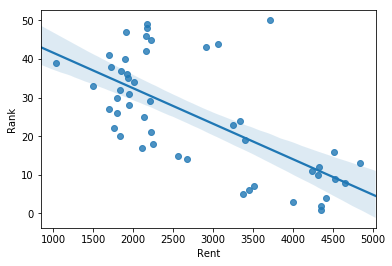

In [168]:
sns.regplot(NYC_Ranked2['Rent'], NYC_Ranked2['Rank'])

As we can see the more expensive a neighborhood is the higher its ranking

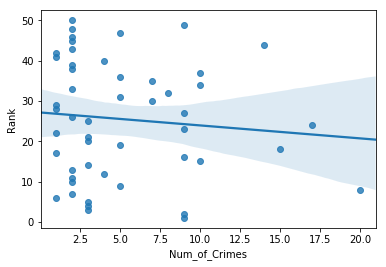

In [169]:
sns.regplot(NYC_Ranked2['Num_of_Crimes'], NYC_Ranked2['Rank'])

The regression line is almost horizontal meaning that the number of crimes has little effect on the Rank

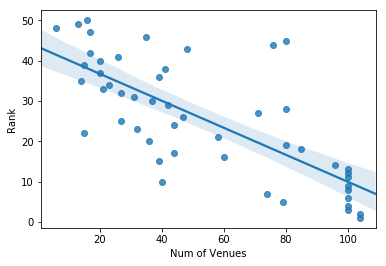

In [170]:
sns.regplot(NYC_Ranked2['Num of Venues'], NYC_Ranked2['Rank'])

The more the number of venues a neighborhood has the higher its ranking

# Multiple Linear Regression

In [171]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
regression = linear_model.LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(normal_NYC[['Rent','Num_of_Crimes','Num of Venues']], NYC_Ranked2[['Rank']])
regression.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Now that we have a linear model of the rank we can predict the ranking of a neighborhood based on its rent, and number of venues

In [172]:
r_score = regression.score(X_test, y_test)
print(r_score)

0.7181039563103191
